In [43]:
import numpy as np 
import pandas as pd
import datetime as dt
from netCDF4 import Dataset
import xarray as xr 
import rioxarray
# import xesmf as xe
# from pyresample import geometry
import os 

Grid point max total rainfall for 20251201:
168.59999
Grid point max total rainfall for 20251202:
170.65
Grid point max total rainfall for 20251203:
177.90001
Grid point max total rainfall for 20251204:
182.4
Grid point max total rainfall for 20251205:
226.5
Grid point max total rainfall for 20251206:
228.9
Grid point max total rainfall for 20251207:
256.6
Grid point max total rainfall for 20251208:
288.1
Grid point max total rainfall for 20251209:
432.09998
Grid point max total rainfall for 20251210:
523.8
Grid point max total rainfall for 20251211:
650.8999
Grid point max total rainfall for 20251212:
687.9999
Grid point max total rainfall for 20251213:
689.9999
Grid point max total rainfall for 20251214:
689.9999
Grid point max total rainfall for 20251215:
768.0999


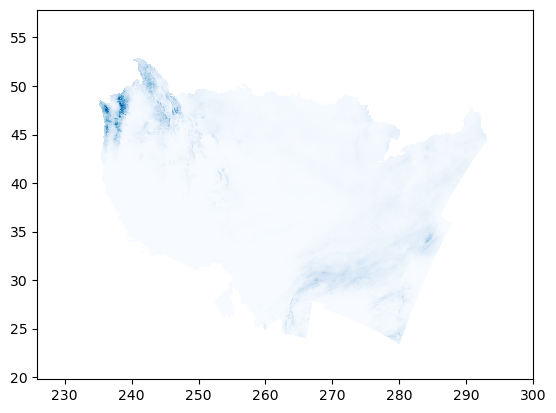

In [44]:
# Calculate rainfall accumuation: Stage IV analysis 
data_dir = '/home/orca/data/in_situ/NCEP_stageIV_QPE/rt'
date_list = pd.date_range(start='2025-12-01', end='2025-12-15', freq='24h')

# Get lat/lon from one historical data file.
fn = os.path.join(
    '/home/orca/data/in_situ/NCEP_stageIV_QPE/2025/daily',
    'st4_conus.2025010112.24h.nc')

with xr.open_dataset(fn) as ds:
    lats = ds['latitude'].data
    lons = ds['longitude'].data

for tt, date in enumerate(date_list):
    date_str = date.strftime('%Y%m%d')
    file_path = os.path.join(data_dir, f'nws_precip_1day_{date_str}_conus.nc')
    
    with xr.open_dataset(file_path) as ds:

        precip_this_day_da = ds['observation']
        precip_this_day = ds['observation'].data[::-1,:] * 25.4  # inches --> mm
        precip_this_day[precip_this_day < -9000.0] = np.nan
        if tt == 0:
            precip = precip_this_day
        else:
            precip += precip_this_day
        
        # Save or process total_rainfall as needed
        print(f'Grid point max total rainfall for {date_str}:')
        print(np.nanmax(precip))

plt.pcolormesh(lons, lats, precip, cmap='Blues')

KDTree built.
Query the KDTree. This may take awhile.
2026-01-30 17:30:06.749225
(15.287720382404904, np.int64(173587))
2026-01-30 17:30:51.796491
[15.28772038 15.28093073]
[173587 173587]
Apply the indices from the KDTree.
768.0999


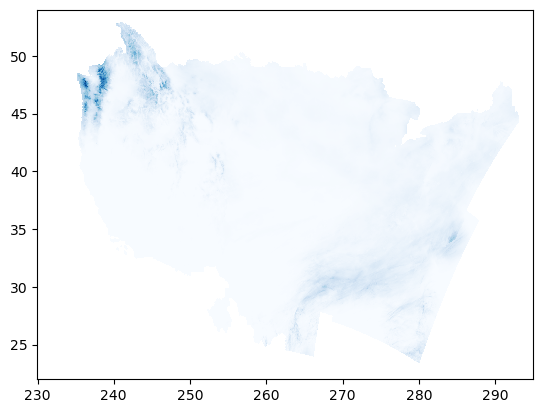

In [50]:
from functions import do_query

# Prepare data for kdtree interpolation.
# target_lats = np.arange(40.0, 45.01, 0.01)
# target_lons = np.arange(250.0, 255.01, 0.01)
# target_lats = np.arange(22.0, 53.25, 0.25)
# target_lons = np.arange(230.0, 295.25, 0.25)

target_lats = np.arange(22.0, 54.01, 0.01)
target_lons = np.arange(230.0, 295.01, 0.01)

target_lon_grid, target_lat_grid = np.meshgrid(target_lons, target_lats)

target_lon_grid_1d = target_lon_grid.flatten()
target_lat_grid_1d = target_lat_grid.flatten()

# Define source and target geometries
source_lon_1d = lons.flatten()
source_lat_1d = lats.flatten()
source_precip_1d = precip.flatten()
keep_mask = ~np.isnan(source_precip_1d)
source_lat_1d = source_lat_1d[keep_mask]
source_lon_1d = source_lon_1d[keep_mask]
source_precip_1d = source_precip_1d[keep_mask]

# keep_mask = np.logical_and(
#     np.logical_and(source_lon_1d > 250.0, source_lon_1d < 255.0),
#     np.logical_and(source_lat_1d > 40.0, source_lat_1d < 45.0)
# )
# source_lat_1d = source_lat_1d[keep_mask]
# source_lon_1d = source_lon_1d[keep_mask]
# source_precip_1d = source_precip_1d[keep_mask]


# Nearest neighbor interpolation to a regular lat-lon grid.



from scipy.spatial import KDTree

KD = KDTree(np.array([source_lon_1d, source_lat_1d]).T)
print("KDTree built.")

## Query which ETOPO01 points are closest to each HYCOM grid point.
print('Query the KDTree. This may take awhile.')

import multiprocessing
NP = 12
print(dt.datetime.now())

output = do_query(0, KD, target_lon_grid_1d, target_lat_grid_1d)
print(output)

with multiprocessing.Pool(processes=NP) as pool:
    Q = pool.starmap(do_query, [(i, KD, target_lon_grid_1d, target_lat_grid_1d) for i in range(len(target_lon_grid_1d))])

print(dt.datetime.now())

# Q comes out as a list of tuples (distance, index)
# I need to separate the distances and indices.

Qdistances = np.array([x[0] for x in Q])
Qindices = np.array([x[1] for x in Q])

print(Qdistances[0:2])
print(Qindices[0:2])


print('Apply the indices from the KDTree.')
distance_threshold = 0.05  # degrees
precip_interp_1d = np.where(Qdistances < distance_threshold, source_precip_1d[Qindices], np.nan)

precip_interp = precip_interp_1d.reshape(target_lon_grid.shape)
print(np.nanmax(precip_interp))
plt.pcolormesh(target_lons, target_lats, precip_interp, cmap='Blues')

In [57]:

# Create xarray dataset with precip, lon, and lat
precip_ds = xr.Dataset(
    data_vars={
        'precip': (['y', 'x'], precip_interp)
    },
    coords={
        'y': (['y',], target_lats),
        'x': (['x',], target_lons)
    }
)

precip_ds['precip'].attrs["units"] = "mm"
precip_ds['precip'].attrs["long_name"] = "Accumulated rainfall"
precip_ds['precip'].rio.write_nodata(0, inplace=True)


print(precip_ds)

# Export to GeoTIFF
# MUST use web mercator!
precip_ds = precip_ds.rio.write_crs("EPSG:4326")

precip_3857 = precip_ds.rio.reproject(
    "EPSG:3857",
    resolution=2000,  # meters (roughly your 4 km grid)
    resampling="nearest"
)

precip_3857.rio.to_raster(
    "rainfall_4km.tif",
    driver="COG",
    compress="DEFLATE",
    dtype="float32",
    nodata=-9999
)





<xarray.Dataset> Size: 83MB
Dimensions:  (y: 3201, x: 6501)
Coordinates:
  * y        (y) float64 26kB 22.0 22.01 22.02 22.03 ... 53.97 53.98 53.99 54.0
  * x        (x) float64 52kB 230.0 230.0 230.0 230.0 ... 295.0 295.0 295.0
Data variables:
    precip   (y, x) float32 83MB nan nan nan nan nan nan ... nan nan nan nan nan


In [52]:
data = rioxarray.open_rasterio('rainfall_4km.tif')
data

<xarray.DataArray (band: 1, y: 2330, x: 3619)> Size: 34MB
[8432270 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * y            (y) float64 19kB 7.17e+06 7.168e+06 ... 2.514e+06 2.512e+06
  * x            (x) float64 29kB -1.447e+07 -1.447e+07 ... -7.235e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    long_name:      Accumulated rainfall
    units:          mm
    _FillValue:     0.0
    scale_factor:   1.0
    add_offset:     0.0

<xarray.DataArray (band: 1, y: 2330, x: 3619)> Size: 34MB
[8432270 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * y            (y) float64 19kB 7.17e+06 7.168e+06 ... 2.514e+06 2.512e+06
  * x            (x) float64 29kB -1.447e+07 -1.447e+07 ... -7.235e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    long_name:      Accumulated rainfall
    units:          mm
    _FillValue:     0.0
    scale_factor:   1.0
    add_offset:     0.0


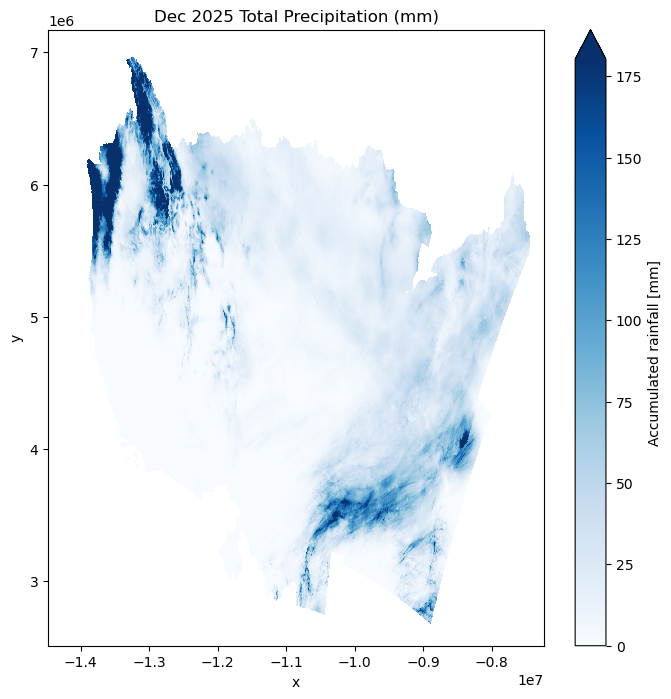

In [53]:
# Plot the raster data

data = rioxarray.open_rasterio('rainfall_4km.tif')
print(data)
plt.figure(figsize=(8, 8))

vmin = data.quantile(0.02).item()
vmax = data.quantile(0.98).item()

# data.sel(band=[1, 1, 1]).plot.imshow(
#     vmin=vmin,
#     vmax=vmax,
#     cmap="Blues"
# )

data.isel(band=0).plot.imshow(
    vmin=vmin,
    vmax=vmax,
    cmap="Blues"
)


plt.title('Dec 2025 Total Precipitation (mm)')
plt.show()

In [54]:
help(precip_ds.rio.reproject)

Help on method reproject in module rioxarray.raster_dataset:

reproject(
    dst_crs: Any,
    *,
    resolution: Optional[Union[float, tuple[float, float]]] = None,
    shape: Optional[tuple[int, int]] = None,
    transform: Optional[Affine] = None,
    resampling: Optional[Union[Resampling | str]] = <Resampling.nearest: 0>,
    nodata: Optional[float] = None,
    **kwargs
) -> xarray.Dataset method of rioxarray.raster_dataset.RasterDataset instance
    Reproject :class:`xarray.Dataset` objects

    .. note:: Only 2D/3D arrays with dimensions 'x'/'y' are currently supported.
        Others are appended as is.
        Requires either a grid mapping variable with 'spatial_ref' or
        a 'crs' attribute to be set containing a valid CRS.
        If using a WKT (e.g. from spatiareference.org), make sure it is an OGC WKT.

    .. note:: To re-project with dask, see
        `odc-geo <https://odc-geo.readthedocs.io/>`__ &
        `pyresample <https://pyresample.readthedocs.io/>`__.

    ..

In [1]:
import rasterio

url = "https://gaia-hazlab-map-data.s3.us-west-2.amazonaws.com/rainfall_4km.tif"
with rasterio.open(url) as src:
    print("CRS:", src.crs)
    print("Width x Height:", src.width, src.height)
    print("Number of bands:", src.count)
    print("Nodata value:", src.nodata)
    print("Min / Max:", src.read(1).min(), src.read(1).max())


CRS: EPSG:3857
Width x Height: 3619 2330
Number of bands: 1
Nodata value: 0.0
Min / Max: nan nan
